In [ ]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import math


LENGTH = 1.


#def initial_condition(x) -> torch.Tensor:
#    res = torch.sign(x-0.5).reshape(-1, 1)
#    return res


class PINN(nn.Module):
    """Simple neural network accepting two features as input and returning a single output
    
    In the context of PINNs, the neural network is used as universal function approximator
    to approximate the solution of the differential equation
    """
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Tanh(), pinning: bool = False):

        super().__init__()

        self.pinning = pinning

        self.layer_in = nn.Linear(1, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act

    def forward(self, x):

        x_stack = torch.cat([x], dim=1)        
        out = self.act(self.layer_in(x_stack))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        logits = self.layer_out(out)

        # if requested pin the boundary conditions 
        # using a surrogate model: (x - 0) * (x - L) * NN(x)
        if self.pinning:
            logits *= (x - x[0]) * (x - x[-1])
        
        return logits

def f(nn_approximator: PINN, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn_approximator(x)


def df(output: torch.Tensor, input: torch.Tensor, order: int = 1) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = output
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            input,
            grad_outputs=torch.ones_like(input),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def dfdt(nn_approximator: PINN, x: torch.Tensor, t: torch.Tensor, order: int = 1):
    """Derivative with respect to the time variable of arbitrary order"""
    f_value = f(nn_approximator, x, t)
    return df(f_value, t, order=order)


def dfdx(nn_approximator: PINN, x: torch.Tensor, order: int = 1):
    """Derivative with respect to the spatial variable of arbitrary order"""
    f_value = f(nn_approximator, x)
    return df(f_value, x, order=order)


def compute_loss(
    nn_approximator: PINN, x: torch.Tensor = None, device = "cpu"
) -> torch.float:
    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """

    eps = 0.1

    # PDE residual
    # interior_loss = dfdt(nn_approximator, x, t, order=2) - G * (dfdx(nn_approximator, x, t, order=2) * f(nn_approximator, x, t) + dfdx(nn_approximator, x, t, order=1).pow(2))
    interior_loss = -eps * dfdx(nn_approximator, x, order=2) + dfdx(nn_approximator, x, order=1)

    #this goes to 0 at 0, so we need to modify left b.c. to be 0 at 0
    exact_loss = f(nn_approximator, x)-((pow( 2.718281828459045,1.0/eps)-1.0) * x +1.0 - pow( 2.718281828459045,x/eps))  / (pow( 2.718281828459045,1.0/eps)-1.0)
    exact_loss = f(nn_approximator,x)-1.0

    boundary_xi = x[-1].reshape(-1, 1) #last point = 1
    boundary_loss_xi = f(nn_approximator, boundary_xi)
    
    boundary_xf = x[0].reshape(-1, 1) #first point = 0
    boundary_loss_xf = -eps * dfdx(nn_approximator, boundary_xf) + f(nn_approximator, boundary_xf)-1.0
    #boundary_loss_xf = f(nn_approximator, boundary_xi)-1.0

#    extra_loss = pow(eps,0.5)*dfdx(nn_approximator, x, order=1)

    # obtain the final MSE loss by averaging each loss term and summing them up
    final_loss = \
        interior_loss.pow(2).mean() + \
        boundary_loss_xf.pow(2).mean() + \
        boundary_loss_xi.pow(2).mean() #+ \
        #exact_loss.pow(2).mean() 

    return final_loss


def train_model(
    nn_approximator: PINN,
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1_000,
    device="cpu"
) -> PINN:

    optimizer = torch.optim.Adam(nn_approximator.parameters(), lr=learning_rate)
    for epoch in range(max_epochs):

        try:

            loss: torch.Tensor = loss_fn(nn_approximator)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 100 == 0:
                print(f"Epoch: {epoch} - Loss: {float(loss):>7f}")

        except KeyboardInterrupt:
            break

    return nn_approximator





In [ ]:
from functools import partial
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#x_domain = [0.0, 0.98 * LENGTH, LENGTH]; n_points_x = 100
eps=0.1
x_domain = [0.0, (1.0-5.0*eps) * LENGTH, LENGTH]; n_points_x = 100
# there is a total of 100 points from 0 to 0.98 and 100 points from 0.98 to 1.0
x_raw_1 = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x)
x_raw_2 = torch.linspace(x_domain[1], x_domain[2], steps=n_points_x)
x_raw = torch.cat((x_raw_1, x_raw_2), dim=0)
#x_raw = torch.normal(mean=0.5, std=0.2, size=(n_points_x,)).sort()[0]
x_raw.requires_grad_()

x = x_raw.reshape(-1, 1).to(device)

exact_sol = ((pow( 2.718281828459045,1.0/eps)-1.0) * x +1.0 - pow( 2.718281828459045,x/eps))  / (pow( 2.718281828459045,1.0/eps)-1.0)

In [ ]:
device

device(type='cuda')

In [ ]:
# plt.figure(1)
# plt.plot(x_raw.detach().numpy(), initial_condition(x_raw).detach().numpy())
# plt.show()

#nn_approximator = PINN(3, 15, pinning=False).to(device) #3 layers, 15 neurons per layer, hiperbolic tangent
nn_approximator = PINN(3, 15, pinning=False).to(device) # this is hiperbolic tangent
#nn_approximator = PINN(3, 15, pinning=False, act=nn.LeakyReLU()).to(device) # this is LeakyReLU
# assert check_gradient(nn_approximator, x, t)

compute_loss(nn_approximator, x=x, device=device)

# train the PINN
loss_fn = partial(compute_loss, x=x, device=device)
nn_approximator_trained = train_model(
    nn_approximator, loss_fn=loss_fn, learning_rate=0.005, max_epochs=10_000, device=device
)

Epoch: 0 - Loss: 0.696007
Epoch: 100 - Loss: 0.309916
Epoch: 200 - Loss: 0.304002
Epoch: 300 - Loss: 0.274306
Epoch: 400 - Loss: 0.000370
Epoch: 500 - Loss: 0.000192
Epoch: 600 - Loss: 0.000157
Epoch: 700 - Loss: 0.000137
Epoch: 800 - Loss: 0.000119
Epoch: 900 - Loss: 0.000102
Epoch: 1000 - Loss: 0.000087
Epoch: 1100 - Loss: 0.000073
Epoch: 1200 - Loss: 0.000061
Epoch: 1300 - Loss: 0.000050
Epoch: 1400 - Loss: 0.000041
Epoch: 1500 - Loss: 0.000032
Epoch: 1600 - Loss: 0.000025
Epoch: 1700 - Loss: 0.000022
Epoch: 1800 - Loss: 0.000015
Epoch: 1900 - Loss: 0.000011
Epoch: 2000 - Loss: 0.000008
Epoch: 2100 - Loss: 0.000006
Epoch: 2200 - Loss: 0.000005
Epoch: 2300 - Loss: 0.000003
Epoch: 2400 - Loss: 0.000003
Epoch: 2500 - Loss: 0.000654
Epoch: 2600 - Loss: 0.000002
Epoch: 2700 - Loss: 0.000014
Epoch: 2800 - Loss: 0.000001
Epoch: 2900 - Loss: 0.000002
Epoch: 3000 - Loss: 0.000276
Epoch: 3100 - Loss: 0.000443
Epoch: 3200 - Loss: 0.000025
Epoch: 3300 - Loss: 0.000002
Epoch: 3400 - Loss: 0.0000

In [ ]:
compute_loss(nn_approximator, x=x, device=device)

tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)

In [ ]:
f(nn_approximator, x)

tensor([[1.0025],
        [1.0025],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0024],
        [1.0023],
        [1.0023],
        [1.0023],
        [1.0023],
        [1.0023],
        [1.0023],
        [1.0023],
        [1.0023],
        [1.0023],
        [1.0023],
        [1.0023],
        [1.0023],
        [1.0023],
        [1.0022],
        [1.0022],
        [1.0022],
        [1.0022],
        [1.0022],
        [1.0022],
        [1.0022],
        [1.0021],
        [1.0021],
        [1.0021],
        [1.0021],
        [1.0021],
        [1.0021],
        [1.0020],
        [1.0020],
        [1.0020],
        [1.0020],
        [1.0019],
        [1.0019],
        [1

In [ ]:
x_draw = x.flatten()
y_draw = f(nn_approximator, x).flatten()
exact_draw = exact_sol.flatten()

In [ ]:
y_draw

tensor([1.0025, 1.0025, 1.0024, 1.0024, 1.0024, 1.0024, 1.0024, 1.0024, 1.0024,
        1.0024, 1.0024, 1.0024, 1.0024, 1.0024, 1.0024, 1.0024, 1.0024, 1.0024,
        1.0024, 1.0024, 1.0024, 1.0024, 1.0024, 1.0023, 1.0023, 1.0023, 1.0023,
        1.0023, 1.0023, 1.0023, 1.0023, 1.0023, 1.0023, 1.0023, 1.0023, 1.0023,
        1.0022, 1.0022, 1.0022, 1.0022, 1.0022, 1.0022, 1.0022, 1.0021, 1.0021,
        1.0021, 1.0021, 1.0021, 1.0021, 1.0020, 1.0020, 1.0020, 1.0020, 1.0019,
        1.0019, 1.0019, 1.0018, 1.0018, 1.0018, 1.0017, 1.0017, 1.0016, 1.0016,
        1.0015, 1.0015, 1.0014, 1.0014, 1.0013, 1.0012, 1.0012, 1.0011, 1.0010,
        1.0009, 1.0009, 1.0008, 1.0007, 1.0006, 1.0005, 1.0004, 1.0002, 1.0001,
        1.0000, 0.9999, 0.9997, 0.9996, 0.9994, 0.9992, 0.9990, 0.9989, 0.9987,
        0.9985, 0.9982, 0.9980, 0.9978, 0.9975, 0.9972, 0.9969, 0.9967, 0.9963,
        0.9960, 0.9960, 0.9957, 0.9953, 0.9949, 0.9945, 0.9941, 0.9936, 0.9932,
        0.9927, 0.9921, 0.9916, 0.9910, 

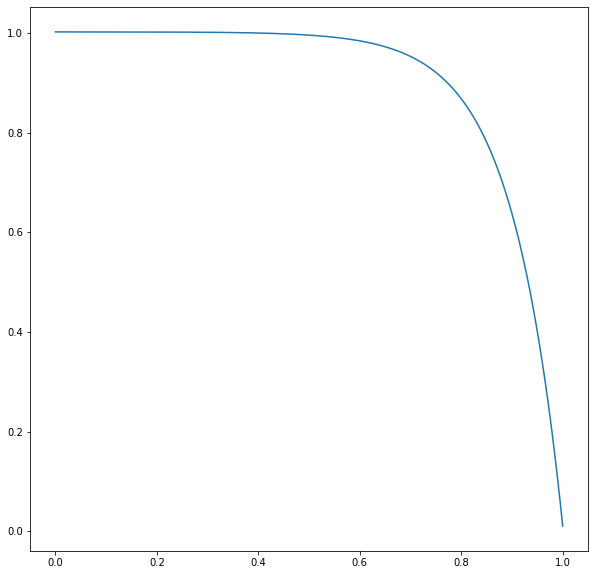

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 10))
plt.plot(x_draw.detach().cpu(), y_draw.detach().cpu())

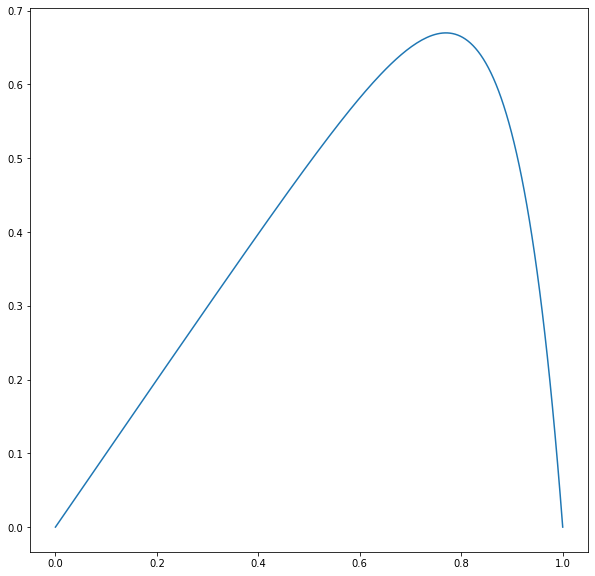

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(10, 10))
plt.plot(x_draw.detach().cpu(), exact_draw.detach().cpu())

In [ ]:
exact_sol

tensor([[nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [nan],
        [n